# Part one : Creating instances

### Here, we assume that you have already downloaded the br.zip file and have opened it. you can also download it here : http://people.brunel.ac.uk/~mastjjb/jeb/orlib/thpackinfo.html

## Please after you've run the box below, enter the br file path into the input box:

In [1]:
import ortec.scientific.benchmarks.loadbuilding.LoadbuildInstance as LBI
import ortec.scientific.benchmarks.loadbuilding.LoadbuildSolution as LBS
%matplotlib inline

In [2]:
doReGenerateAllBRFiles = True
path = 'C:\\Users\\kev_i\\Google Drive\\RWTH DDS 2020\\Analytics Project\\Programs\\3dbinpacking-master_ROOZBEH2\\3dbinpacking-master\\br'

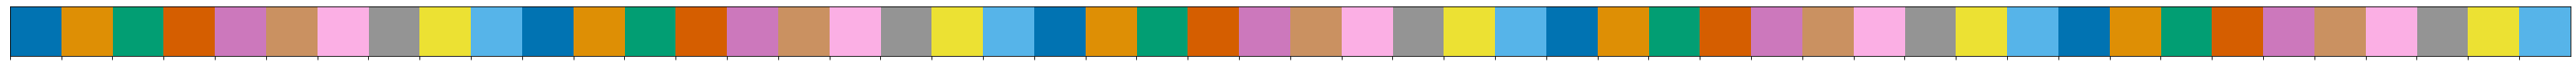

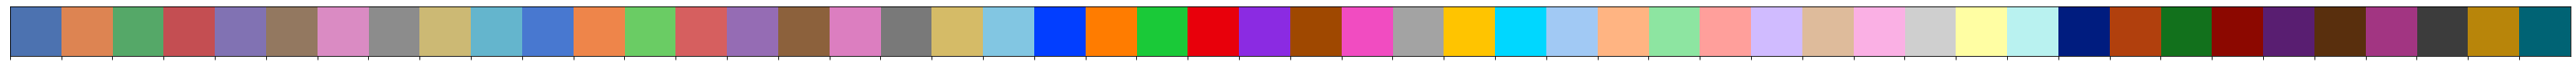

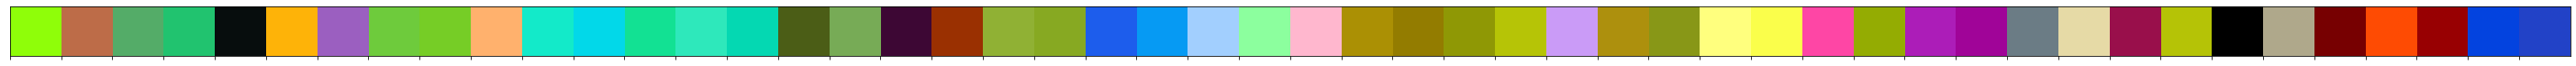

In [3]:
def RGB2HEX( colors ):
    return [ '#%02X%02X%02X' % tuple(map( lambda x: int(x * 255), rgb )) for rgb in colors ]
    
def ColorsCombinedPalettes():
    palettes = [ "deep", "muted", "bright", "pastel", "dark", "colorblind" ]
    import seaborn as sns
    return RGB2HEX( [ color for palette in palettes for color in sns.color_palette(palette) ] )[:50]

def ColorsXKCD():
    import seaborn as sns
    return [ sns.xkcd_rgb[key] for key in sorted( list( sns.xkcd_rgb.keys() ) ) ][:50]

def ColorsColorBlind():
    import seaborn as sns
    return RGB2HEX( sns.color_palette("colorblind", 50) )

import seaborn as sns
sns.palplot(ColorsColorBlind())
sns.palplot(ColorsCombinedPalettes())
sns.palplot(ColorsXKCD())

In [4]:
def ReadHomogeneous( source, type = int ):
    array = []
    with open(source) as f:
        array = [[type(x) for x in line.split()] for line in f]
    return array

def Colors():
    return ColorsColorBlind()

def SkeletonString():
    return """description:
  set: Bischoff & Ratcliff
  name: ''
constraints:
- name: orientation
- name: support
objectives:
- name: average_fill_rate
  weight: 1.0
  priority: 1
- name: item_count
  weight: 1.0
  priority: 2
data:
  containerkinds:
  - id: 1
    quantity: 1
    loadingspaces:
    - id: 1
      position: 0,0,0
      size:
        length: Null
        width: Null
        height: Null
  palletkinds: []
  boxkinds: []
  itemkinds:
  - id: 1
    color: Null
    quantity: Inf
    support: 1.0
    size:
      length: Null
      width: Null
      height: Null
    orientations: HLW,HWL,LHW,LWH,WHL,WLH"""

def MakeEmptyInstance():
    import yaml
    return yaml.load( SkeletonString(), Loader=yaml.FullLoader )

def MakeName( data, idxCollection, idx ):
    return str(idxCollection) + '.' + str(data[idx][0])   

def DefineItem( item, datarow, color ):
    import copy
    item = copy.deepcopy(item)    
    item['id'] = datarow[0]
    item['color'] = color
    item['quantity'] = datarow[-1]
    item['size']['length'] = datarow[1]
    item['size']['width'] = datarow[3]
    item['size']['height'] = datarow[5]
    o = item['orientations'].split(',')
    oL = oW = oH = []
    if datarow[2] == 1:
        oL = [x for x in o if x[2] == 'L' ]
    if datarow[4] == 1:
        oW = [x for x in o if x[2] == 'W' ]
    if datarow[6] == 1:
        oH = [x for x in o if x[2] == 'H' ]
    item['orientations'] = ",".join(oL+oW+oH)
    return item

def ExtractInstance( data, idxCollection, idx ):
    instance = MakeEmptyInstance()
    instance['description']['name'] = MakeName( data, idxCollection, idx )
    containerSize = instance['data']['containerkinds'][0]['loadingspaces'][0]['size']
    containerSize['length'] = data[idx+1][0]
    containerSize['width'] = data[idx+1][1]
    containerSize['height'] = data[idx+1][2]
    item = instance['data']['itemkinds'][0]
    current = idx+3
    iterItems = iter(range( data[idx+2][0]) )
    next(iterItems)
    color = iter(Colors())
    for i in iterItems:
        current = current + 1
        instance['data']['itemkinds'].append( DefineItem( item, data[current], next(color) ) )
    instance['data']['itemkinds'][0] = DefineItem( item, data[idx+3], next(color) )
    return instance

def ExtractAllInstances( idxCollection, path='.' ):
    import os
    if not os.path.exists(path+'/yaml'):
        os.makedirs(path+'/yaml')
    import yaml
    yaml.add_representer(dict, lambda self, data: yaml.representer.SafeRepresenter.represent_dict(self, data.items()))
    data = ReadHomogeneous( path+'/txt/br' + str(idxCollection) + '.txt' )
    for i in [i for i, x in enumerate(data) if len(x) == 2]:
        with open(path+'/yaml/br' + MakeName( data, idxCollection, i ) + '.yaml' , 'w') as outfile:
            yaml.dump( ExtractInstance( data, idxCollection, i ), outfile, default_flow_style = False )        

In [5]:
if doReGenerateAllBRFiles:
    for i in range(10): 
        ExtractAllInstances( i+1, path )

# We have now created the 1000 instances.

# Part Two: Packing

## Source Code:

### Rotations and Axis:

In [6]:
class RotationType:
    RT_WHD = 0
    RT_HWD = 1
    RT_HDW = 2
    RT_DHW = 3
    RT_DWH = 4
    RT_WDH = 5

    ALL = [RT_WHD, RT_HWD, RT_HDW, RT_DHW, RT_DWH, RT_WDH]


class Axis:
    WIDTH = 0
    HEIGHT= 1
    DEPTH = 2

    ALL = [WIDTH, HEIGHT, DEPTH]

### Intersections:

In [7]:
def intersect(item1, item2):
    return (
        rect_intersect(item1, item2, Axis.WIDTH, Axis.HEIGHT)
    )

def intersect_area(item1, item2):
    shared_area_proportion = 0.0
    if intersect(item1, item2):
        if(item1.position[0]+item1.dimension[0]<=item2.position[0]+item2.dimension[0]):
            dx = item1.position[0]+item1.dimension[0]-max(item1.position[0],item2.position[0])
        else:
            dx = item2.position[0]+item2.dimension[0]-max(item1.position[0],item2.position[0])
            
        if(item1.position[1]+item1.dimension[1]<=item2.position[1]+item2.dimension[1]):
            dy = item1.position[1]+item1.dimension[1]-max(item1.position[1],item2.position[1])
        else:
            dy = item2.position[1]+item2.dimension[1]-max(item1.position[1],item2.position[1])
        
        w = item2.dimension[0]
        h = item2.dimension[1]
        shared_area_proportion = (float(dx)*float(dy))/(float(w)*float(h))
     
    return shared_area_proportion


def get_limit_number_of_decimals(number_of_decimals):
    return Decimal('1.{}'.format('0' * number_of_decimals))


def set_to_decimal(value, number_of_decimals):
    number_of_decimals = get_limit_number_of_decimals(number_of_decimals)

    return Decimal(value).quantize(number_of_decimals)
from decimal import Decimal


def rect_intersect(item1, item2, x, y):
    d1 = item1.get_dimension()
    d2 = item2.get_dimension()

    cx1 = item1.position[x] + d1[x]/2
    cy1 = item1.position[y] + d1[y]/2
    cx2 = item2.position[x] + d2[x]/2
    cy2 = item2.position[y] + d2[y]/2

    ix = max(cx1, cx2) - min(cx1, cx2)
    iy = max(cy1, cy2) - min(cy1, cy2)

    return ix < (d1[x]+d2[x])/2 and iy < (d1[y]+d2[y])/2

### Bin and Packs:

In [8]:

DEFAULT_NUMBER_OF_DECIMALS = 3
START_POSITION = [0, 0, 0]


class Item:
    def __init__(self, name, width, height, depth, weight):
        self.name = name
        self.width = width
        self.height = height
        self.depth = depth
        self.weight = weight
        self.rotation_type = 0
        self.position = START_POSITION
        self.number_of_decimals = DEFAULT_NUMBER_OF_DECIMALS
        self.dimension = [0,0,0]
        self.position_elevated = [0,0,0] #Depth(Actually height but in this coding, W*L*H convention is Width*Height*Depth) value in terms of total elevation from z=0
  
    def format_numbers(self, number_of_decimals):
        self.width = set_to_decimal(self.width, number_of_decimals)
        self.height = set_to_decimal(self.height, number_of_decimals)
        self.depth = set_to_decimal(self.depth, number_of_decimals)
        self.weight = set_to_decimal(self.weight, number_of_decimals)
        self.number_of_decimals = number_of_decimals

    def string(self):
        return "%s(%sx%sx%s, weight: %s) pos(%s)- dim(%s) rt(%s) vol(%s)" % (
            self.name, self.width, self.height, self.depth, self.weight,
            self.position, self.dimension, self.rotation_type, self.get_volume()
        )

    def get_volume(self):
        return set_to_decimal(
            self.width * self.height * self.depth, self.number_of_decimals
        )

    def get_dimension(self):
        if self.rotation_type == RotationType.RT_WHD:
            dimension = [self.width, self.height, self.depth]
            self.dimension = dimension
            self.position_elevated = [self.position[0],self.position[1],self.position[2]+dimension[2]]
        elif self.rotation_type == RotationType.RT_HWD:
            dimension = [self.height, self.width, self.depth]
            self.dimension = dimension
            self.position_elevated = [self.position[0],self.position[1],self.position[2]+dimension[2]]
        elif self.rotation_type == RotationType.RT_HDW:
            dimension = [self.height, self.depth, self.width]
            self.dimension = dimension
            self.position_elevated = [self.position[0],self.position[1],self.position[2]+dimension[2]]
        elif self.rotation_type == RotationType.RT_DHW:
            dimension = [self.depth, self.height, self.width]
            self.dimension = dimension
            self.position_elevated = [self.position[0],self.position[1],self.position[2]+dimension[2]]
        elif self.rotation_type == RotationType.RT_DWH:
            dimension = [self.depth, self.width, self.height]
            self.dimension = dimension
            self.position_elevated = [self.position[0],self.position[1],self.position[2]+dimension[2]]
        elif self.rotation_type == RotationType.RT_WDH:
            dimension = [self.width, self.depth, self.height]
            self.position_elevated = [self.position[0],self.position[1],self.position[2]+dimension[2]]
            self.dimension = dimension
        else:
            dimension = [0,0,0]
            self.dimension = dimension
            self.position_elevated = [0,0,0]

        return dimension


class Bin:
    def __init__(self, name, width, height, depth, max_weight):
        self.name = name
        self.width = width
        self.height = height
        self.depth = depth
        self.max_weight = max_weight
        self.items = []
        self.unfitted_items = []
        self.number_of_decimals = DEFAULT_NUMBER_OF_DECIMALS
        
        #For layers at z>0 calculations - These are temporary values
        self.item_depths = []
        self.apparent_items = []
        self.apparent_items_temp = [] #For calculation of total intersect_area under an item's layer to assess stackability (Center of Gravity Approximation)

    def format_numbers(self, number_of_decimals):
        self.width = set_to_decimal(self.width, number_of_decimals)
        self.height = set_to_decimal(self.height, number_of_decimals)
        self.depth = set_to_decimal(self.depth, number_of_decimals)
        self.max_weight = set_to_decimal(self.max_weight, number_of_decimals)
        self.number_of_decimals = number_of_decimals

    def string(self):
        return "%s(%sx%sx%s, max_weight:%s) vol(%s)" % (
            self.name, self.width, self.height, self.depth, self.max_weight,
            self.get_volume()
        )

    def get_volume(self):
        return set_to_decimal(
            self.width * self.height * self.depth, self.number_of_decimals
        )

    def get_total_weight(self):
        total_weight = 0

        for item in self.items:
            total_weight += item.weight

        return set_to_decimal(total_weight, self.number_of_decimals)

    def put_item(self, item, pivot, axis, w):
        fit = False
        valid_item_position = item.position
        item.position = pivot

        for i in range(0, len(RotationType.ALL)):
            if pivot[2]>0:
                break
            item.rotation_type = i
            dimension = item.get_dimension()
            if axis == 1:
                #Height(L), Height(R) Check - when height_l is false, check height_r validity
                
                if (
                    self.width < pivot[0] + dimension[0] or
                    self.height < pivot[1] + dimension[1] or
                    self.depth < pivot[2] + dimension[2]
                    ):
                    height_l = False
                    
                    if (
                        pivot[0]+w-dimension[0] < 0 or
                        self.height < pivot[1] + dimension[1] or
                        self.depth < pivot[2] + dimension[2]
                        ):
                        height_r1 = False
                        
                        if (
                            self.width < pivot[0]+w+dimension[0] or
                            pivot[1] - dimension[1] < 0 or
                            self.depth < pivot[2] + dimension[2]
                            ):
                            height_r2 = False
                        else:
                            height_r2 = True
                            item.position = [pivot[0]+w,pivot[1]-dimension[1],pivot[2]]
                            
                    else:
                        height_r1 = True
                        item.position = [pivot[0]+w-dimension[0],pivot[1],pivot[2]]
                        
                else:
                    height_l = True
                    
                    

                if height_l == False and height_r1 == False and height_r2 == False:
                    item.position = pivot
                    continue
                
            else:
                if (
                    self.width < pivot[0] + dimension[0] or
                    self.height < pivot[1] + dimension[1] or
                    self.depth < pivot[2] + dimension[2]
                    ):
                    continue
    
            fit = True
            
            
            for current_item_in_bin in self.apparent_items:
                if current_item_in_bin.position[2]==0:
                    if intersect(current_item_in_bin, item):
                        fit = False
                        break
            if not fit:
                item.position = pivot
                continue
            
            #if(item.name=='10' and axis==1 and pivot[0]==0 and float(pivot[1])==7.873):
                #print(item.position)
            

            for current_item_in_bin in self.items:
                if intersect(current_item_in_bin, item):
                    fit = False
                    break
            if not fit:
                item.position = pivot
                continue
            
            
            

            if fit:
                if self.get_total_weight() + item.weight > self.max_weight:
                    fit = False
                    return fit
                

                self.items.append(item)
                self.item_depths.append(item.position_elevated[2])

            if not fit:
                item.position = valid_item_position

            return fit

        if not fit:
            item.position = valid_item_position

        return fit
    
    def put_apparent_item(self,apparent_item):
        self.apparent_items.append(apparent_item)
        
    def put_item_subsequent_layers(self, item, pivot, axis, w, base_z, z_layers):
        fit = False
        valid_item_position = item.position
        item.position = pivot

        for i in range(0, len(RotationType.ALL)):
            if pivot[2]>base_z:
                break
            item.rotation_type = i
            dimension = item.get_dimension()
            if axis == 1:
                #Height(L), Height(R) Check - when height_l is false, check height_r validity
                
                
                if (
                    self.width < pivot[0] + dimension[0] or
                    self.height < pivot[1] + dimension[1] or
                    self.depth < pivot[2] + dimension[2]
                    ):
                    height_l = False
                    
                    if (
                        pivot[0]+w-dimension[0] < 0 or
                        self.height < pivot[1] + dimension[1] or
                        self.depth < pivot[2] + dimension[2]
                        ):
                        height_r1 = False
                        
                        if (
                            self.width < pivot[0]+w+dimension[0] or
                            pivot[1] - dimension[1] < 0 or
                            self.depth < pivot[2] + dimension[2]
                            ):
                            height_r2 = False
                        else:
                            height_r2 = True
                            item.position = [pivot[0]+w,pivot[1]-dimension[1],pivot[2]]
                            
                    else:
                        height_r1 = True
                        item.position = [pivot[0]+w-dimension[0],pivot[1],pivot[2]]
                else:
                    height_l = True

                if height_l == False and height_r1 == False and height_r2 == False:
                    item.position = pivot
                    continue
                
            else:
                if (
                    self.width < pivot[0] + dimension[0] or
                    self.height < pivot[1] + dimension[1] or
                    self.depth < pivot[2] + dimension[2]
                    ):
                    continue

            fit = True
            #if(item.name=='15' and float(base_z)==3.969):
            #    print(item.position,item.dimension,axis)

            for current_item_in_bin in self.apparent_items:
                if intersect(current_item_in_bin, item):
                    fit = False
                    break
            if not fit:
                item.position = pivot
                continue
            
            #Testing how much xy-plane area of the item to be stacked is shared with other items underneath 
            #It's an approximation for center of gravity consideration. If the shared_area is less than 60%, the item does not get stacked because the item shouldn't float
            area = 0
            for temp_item in self.apparent_items_temp:
                area += intersect_area(temp_item, item)
            if area<1:
                fit=False 
            print("Item_"+item.name+" at layer z="+str(base_z)+", area shared with other objects underneath: ",area)
            

            if fit:
                if self.get_total_weight() + item.weight > self.max_weight:
                    fit = False
                    return fit
                

                self.items.append(item)
                self.item_depths.append(item.position_elevated[2])

            if not fit:
                item.position = valid_item_position

            return fit

        if not fit:
            item.position = valid_item_position

        return fit
    


class Packer:
    def __init__(self):
        self.bins = []
        self.items = []
        self.unfit_items = []
        self.total_items = 0

    def add_bin(self, bin):
        return self.bins.append(bin)

    def add_item(self, item):
        self.total_items = len(self.items) + 1

        return self.items.append(item)

    def pack_to_bin(self, bin, item):
        fitted = False

        if not bin.items:
            response = bin.put_item(item, START_POSITION,0,0)

            if not response:
                bin.unfitted_items.append(item)

            return

        for axis in range(0, 3):
            items_in_bin = bin.items

            for ib in items_in_bin:
                pivot = [0, 0, 0]
                w, h, d = ib.get_dimension()
                if axis == Axis.WIDTH:
                    pivot = [
                        ib.position[0] + w,
                        ib.position[1],
                        ib.position[2]
                    ]
                elif axis == Axis.HEIGHT:
                    pivot = [
                        ib.position[0],
                        ib.position[1] + h,
                        ib.position[2],                        
                    ]

                elif axis == Axis.DEPTH:
                    pivot = [
                        ib.position[0],
                        ib.position[1],
                        ib.position[2] + d
                    ]

                if bin.put_item(item, pivot, axis, w):
                    
                    fitted = True
                    break
            if fitted:
                break

        if not fitted:
            #first try fitting in the next layer
            z_layers = [0]
            k=0
            while True:
                base_z = min(num for num in bin.item_depths if num>k)
                #print(base_z)
                z_layers.append(base_z)
                
                #Finding stacked items whose elevation makes the base_z and save at the temporary bin.apparent_items_temp
                bin.apparent_items_temp=[]
                for item_ in bin.items:
                    if item_.position_elevated[2]==base_z:
                        bin.apparent_items_temp.append(item_)
            
                #Making apparent items for base_z
                    
                offset_depths = [x-base_z for x in bin.item_depths]
                if base_z==max(bin.item_depths):
                    pivs=[]
                    count_A=0
                    count_B=0
                    for d in offset_depths:
                        if d==0:
                            try:
                                piv = bin.apparent_items[count_A].position
                                piv[2] = base_z
                                pivs.append(piv)
                                count_A+=1
                            except:
                                piv = [0,0,0]
                                piv[0] = bin.items[count_B].position[0]
                                piv[1] = bin.items[count_B].position[1]
                                piv[2] = base_z
                                pivs.append(piv)
                                count_B+=1
                
                bin.apparent_items = []
                for key,d in enumerate(offset_depths):
                    if d>0:
                        #This xy-plane is occupied
                        #apparent_item instance has to be defined to mask this area on xy-plane
                        apparent_item = Item("apparent_"+bin.items[key].name,bin.items[key].dimension[0],bin.items[key].dimension[1],d,0)
                        apparent_item.position = [bin.items[key].position[0],bin.items[key].position[1],base_z]
                        apparent_item.dimension = [bin.items[key].dimension[0],bin.items[key].dimension[1],d]
                        apparent_item.position_elevated = [bin.items[key].position[0],bin.items[key].position[1],d+base_z]
                        #This apprent_item has to be put in the bin to mask the area already occupied by the actual item
                        bin.put_apparent_item(apparent_item)

 
                #Now, put the actual item at the base_z layer
                if not bin.apparent_items:
                    responses=[]
                    for piv in pivs:
                        response = bin.put_item_subsequent_layers(item, piv, 0, 0, base_z, z_layers)
                        if response==1:
                            responses.append(response)
                            break
                        
                    fit_test=0
                    for response in responses:
                        fit_test+=response
                    if fit_test==0:
                        bin.unfitted_items.append(item)
                    return

     
                        
                for axis in range(0, 3):
                    items_in_bin = bin.apparent_items
                

                    for ib in items_in_bin:
                        pivot = [0, 0, 0]
                        [w, h, d] = ib.dimension
                        if axis == Axis.WIDTH:
                            pivot = [
                                ib.position[0] + w,     #ib.position[2]=base_z
                                ib.position[1],
                                ib.position[2]
                                ]   
                        elif axis == Axis.HEIGHT: 
                            pivot = [
                                ib.position[0],
                                ib.position[1] + h,
                                ib.position[2]
                                ]
                        elif axis == Axis.DEPTH:
                            pivot = [
                                ib.position[0],
                                ib.position[1],
                                ib.position[2] + d
                                ]

                        if bin.put_item_subsequent_layers(item, pivot, axis, w, base_z, z_layers):
                            fitted = True
                            #Making apparent items at z<base_z among z_layers values when the item is stacked
                            for l,ly in enumerate(z_layers):
                                assert(ly<=base_z)
                                for ap_i in bin.apparent_items:
                                    if ap_i.name.startswith("apparent_") and ly<base_z:
                                        apparent_item = Item("lower_projection_"+ap_i.name,ap_i.dimension[0],ap_i.dimension[1],base_z-ly,0)
                                        apparent_item.position = [ap_i.position[0],ap_i.position[1],ly]
                                        apparent_item.dimension = [ap_i.dimension[0],ap_i.dimension[1],base_z-ly]
                                        apparent_item.position_elevated = [ap_i.position[0],ap_i.position[1],base_z]
                                        bin.put_apparent_item(apparent_item)
                                for item in bin.items:
                                    if item.position[2]==base_z and ly<base_z:
                                        apparent_item = Item("lower_projection_"+item.name,item.dimension[0],item.dimension[1],base_z-ly,0)
                                        apparent_item.position = [item.position[0],item.position[1],ly]
                                        apparent_item.dimension = [item.dimension[0],item.dimension[1],base_z-ly]
                                        apparent_item.position_elevated = [item.position[0],item.position[1],base_z]
                                        bin.put_apparent_item(apparent_item)
                                        
                            break
                    if fitted:
                        return
                    else:
                        if axis==2:
                            break
                    if axis==2:
                        break
                k=base_z
                if k==max(bin.item_depths):
                    break
            
            print(z_layers)
            bin.unfitted_items.append(item)

    def pack(
        self, bigger_first=False, distribute_items=False,
        number_of_decimals=DEFAULT_NUMBER_OF_DECIMALS
    ):
        for bin in self.bins:
            bin.format_numbers(number_of_decimals)

        for item in self.items:
            item.format_numbers(number_of_decimals)

        #self.bins.sort(
        #    key=lambda bin: bin.get_volume(), reverse=bigger_first
        #)
        #self.items.sort(
        #    key=lambda item: item.get_volume(), reverse=bigger_first
        #)

        #for bin in self.bins:
            #for item in self.items:
        self.pack_to_bin(bin, item)

        if distribute_items:
            for item in bin.items:
                self.items.remove(item)



### Importing required libraries

In [9]:
#from py3dbp import Packer, Bin, Item
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import matplotlib.pyplot as plt
import random
import easygui
import yaml

## Choose the .yaml file to read from your computer

In [10]:
ChoosenFile = easygui.fileopenbox()

### Reading .yaml and extracting data:

In [12]:
def containerSize(instance):
    
    with open(instance) as d:
        skeleton = yaml.load(d, Loader=yaml.FullLoader)
        
    truckX = skeleton['data']['containerkinds'][0]['loadingspaces'][0]['size']['length']
    truckY = skeleton['data']['containerkinds'][0]['loadingspaces'][0]['size']['width']
    truckZ = skeleton['data']['containerkinds'][0]['loadingspaces'][0]['size']['height']
    
    return (truckX,truckY,truckZ)

def addItems(instance):
    items = []
    with open(ChoosenFile) as d:
        instance = yaml.load(d, Loader=yaml.FullLoader)
    for i in range(len(instance['data']['itemkinds'])):
        for j in range(instance['data']['itemkinds'][i]['quantity']):
            items.append(Item(name= 'ID_' + str(i+1),
                              width= instance['data']['itemkinds'][i]['size']['width'],
                              depth= instance['data']['itemkinds'][i]['size']['length'],
                              height= instance['data']['itemkinds'][i]['size']['height'],
                              weight=1))
    return items

items = addItems(ChoosenFile)

### Adding Container:

In [13]:
packer = Packer()

(truckX, truckY, truckZ) = containerSize(ChoosenFile)

a= Bin('Container', truckX, truckY, truckZ, 3000000.0)
packer.add_bin(a)

### Adding Boxes:

In [14]:
for item in items:
    packer.add_item(item)
    packer.pack()

positions = []
sizes = []
colors = []


Item_ID_2 at layer z=102.000, area shared with other objects underneath:  1.0
Item_ID_2 at layer z=102.000, area shared with other objects underneath:  1.0


### Show Fitted Boxes:

In [15]:
for  b  in  packer . bins :
    print("----------------------------------------------------------------------------------------------")
    print('TOTAL ITEMS: ', len(b.items) + len(b.unfitted_items)) 
    print("FITTED ITEMS: " + str(len(b.items))) 
    for  item  in  b . items :
        x = float(item.position[0])
        y = float(item.position[1])
        z = float(item.position[2])
        positions.append((x,y,z))
        sizes.append((float(item.get_dimension()[0]), float(item.get_dimension()[1]), float(item.get_dimension()[2])))
        #print("====> ", item.string())
    print("----------------------------------------------------------------------------------------------")

    print("UNFITTED ITEMS: " + str(len(b.unfitted_items)))

    for item in b.unfitted_items:
        print("==> ", item.string())
            
    print("----------------------------------------------------------------------------------------------")

----------------------------------------------------------------------------------------------
TOTAL ITEMS:  127
FITTED ITEMS: 51
----------------------------------------------------------------------------------------------
UNFITTED ITEMS: 76
==>  ID_2(78.000x39.000x102.000, weight: 1.000) pos([0, 0, 0])- dim([Decimal('78.000'), Decimal('102.000'), Decimal('39.000')]) rt(5) vol(310284.000)
==>  ID_2(78.000x39.000x102.000, weight: 1.000) pos([0, 0, 0])- dim([Decimal('78.000'), Decimal('102.000'), Decimal('39.000')]) rt(5) vol(310284.000)
==>  ID_2(78.000x39.000x102.000, weight: 1.000) pos([0, 0, 0])- dim([Decimal('78.000'), Decimal('102.000'), Decimal('39.000')]) rt(5) vol(310284.000)
==>  ID_2(78.000x39.000x102.000, weight: 1.000) pos([0, 0, 0])- dim([Decimal('78.000'), Decimal('102.000'), Decimal('39.000')]) rt(5) vol(310284.000)
==>  ID_2(78.000x39.000x102.000, weight: 1.000) pos([0, 0, 0])- dim([Decimal('78.000'), Decimal('102.000'), Decimal('39.000')]) rt(5) vol(310284.000)
==>  I

### Packing Results:

In [16]:
def containerVolume():
    ContainerVolume = containerSize(ChoosenFile)[0] * containerSize(ChoosenFile)[1] * containerSize(ChoosenFile)[2]
    return ContainerVolume

ItemsVolume = 0
unfittedVolumes = 0
for i in b.items:
    ItemsVolume = ItemsVolume + int(i.get_volume())
for i in b.unfitted_items:
    unfittedVolumes = unfittedVolumes + int(i.get_volume())
    UsedItemsVolume = ItemsVolume # - unfittedVolumes
    
print('Volume all items before packing:', ItemsVolume + unfittedVolumes)
print('Container Volume:', containerVolume())
print('Packed Items Volume:', ItemsVolume) 
print('Used Volume: ', ItemsVolume/containerVolume())


Volume all items before packing: 29963259
Container Volume: 30089620
Packed Items Volume: 11800539
Used Volume:  0.3921797284246195


# Part three: Visualization

### Front Visualization

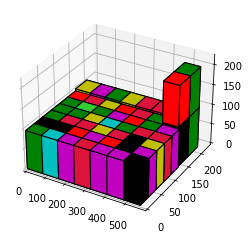

In [17]:
    def cuboid_data2(o, size=(2,2,2)):
        X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
            [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
            [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
            [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
            [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
            [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
        X = np.array(X).astype(float)
        for  i  in  range ( 3 ):
            X[:,:,i] *= size[i]
        X += np.array(o)
        return X

    def plotCubeAt2(positions,sizes=None,colors=None, **kwargs):
        if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
        if not isinstance(sizes,(list,np.ndarray)): sizes=[(1,1,1)]*len(positions)
        g = []
        for p,s,c in zip(positions,sizes,colors):
            g.append( cuboid_data2(p, size=s) )
        return Poly3DCollection(np.concatenate(g),  
                                facecolors=np.repeat(colors,6), **kwargs)
        

    colorList = ["crimson","limegreen","g","r","c","m","y","k"]

    for  i  in  range ( len ( b . items )):
        (x,y,z)=item.position
        (w,h,d)=item.dimension
        position=(float(x),float(y),float(z))
        size=(float(w),float(h),float(d))
        positions.append(position)
        sizes.append(size)
        f  =  random . randint ( 0 , 7 )
        colors.append(colorList[f])

    #print(colors)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_aspect('auto')

    pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="k")
    ax.add_collection3d(pc)    

    ax.set_xlim([0,truckX])
    ax.set_ylim([0,truckY])
    ax.set_zlim([0,truckZ])

    plt.show()

### Back Visualization

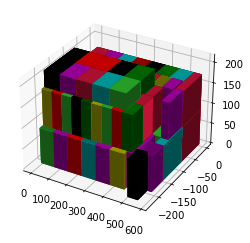

In [99]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

def cuboid_data(o, size=(10,10,10)):
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  
    y = [[-o[1], -o[1], -o[1] - w, -o[1] - w, -o[1]],  
         [-o[1], -o[1], -o[1] - w, -o[1] - w, -o[1]],  
         [-o[1], -o[1], -o[1], -o[1], -o[1]],          
         [-o[1] - w, -o[1] - w, -o[1] - w, -o[1] - w, -o[1] - w]]   
    z = [[o[2], o[2], o[2], o[2], o[2]],                       
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],   
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],               
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]               
    return np.array(x), np.array(y), np.array(z)

def plotCubeAt(pos=(0,0,0), size=(3,3,3), ax=None,**kwargs):
    colorList = ["crimson","limegreen","g","r","c","m","y","k"]
    # Plotting a cube element at position pos
    if ax !=None:
        X, Y, Z = cuboid_data( pos, size )
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, **kwargs)
        
positions=[]
sizes=[]
colors=[]

for key,item in enumerate(a.items):
    (x,y,z)=item.position
    (w,h,d)=item.dimension
    position=(float(x),float(y),float(z))
    size=(float(w),float(h),float(d))
    color=(1/(key+1),1,0.0001*key)
    positions.append(position)
    sizes.append(size)
    f  =  random . randint ( 0 , 7 )
    colors.append(colorList[f])


fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.set_aspect('equal')

for p,s,c in zip(positions,sizes,colors):
    plotCubeAt(pos=p, size=s, ax=ax, color=c)


plt.show()


### Upper 2D View

In [58]:
from bokeh.io import output_file, show
from bokeh.plotting import figure

# instantiating the figure object  
graph = figure(title = "Bokeh Rectangle Graph")  

# name of the x-axis  
graph.xaxis.axis_label = "x-axis"

# name of the y-axis  
graph.yaxis.axis_label = "y-axis"

# points to be plotted 
x = [] 
y = [] 
w= [] 
h = [] 
color = []
fill_alpha = []
for i in a.items:
    w_ = i.dimension[0]
    h_ = i.dimension[1]
    x_ = i.position[0]+ w_/2
    y_ = -i.position[1] - h_/2
    w.append(w_)
    h.append(h_)
    x.append(x_)
    y.append(y_)
    
    color.append("yellow")
    fill_alpha.append(i.dimension[2]/a.depth)


# plotting the graph  
graph.rect(x, 
           y, 
           w, 
           h, 
           color = color, 
           fill_alpha = fill_alpha)  

# displaying the model  
show(graph)
